## SETUP

In [1]:
import os
os.getcwd()

'C:\\Users\\HP\\Desktop\\chi-limited-analysis-py311\\notebooks'

## IMPORTS & CONFIGURATION

In [2]:
# ============================================================================
# CHI LIMITED - FEATURE ENGINEERING
# Notebook 04: Prepare Data for Machine Learning Models
# ============================================================================

import pandas as pd
import numpy as np
import sqlite3
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats


# Configure
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', None)

#plt.style.use('seaborn-v0_8-whitegrid')
#plt.rcParams['figure.figsize'] = (14, 7)
#sns.set_palette("Set2")

print("• Libraries imported!")
print(" Ready for feature engineering")

• Libraries imported!
 Ready for feature engineering


#### Load Data from Database

In [3]:
# ============================================================================
# LOAD DATA
# ============================================================================

print("• Loading data from database...")

conn = sqlite3.connect('../chi_limited.db')

# Load all tables
df_sales = pd.read_sql_query("SELECT * FROM fact_sales", conn)
df_time = pd.read_sql_query("SELECT * FROM dim_time", conn)
df_product = pd.read_sql_query("SELECT * FROM dim_product", conn)
df_geography = pd.read_sql_query("SELECT * FROM dim_geography", conn)
df_promotions = pd.read_sql_query("SELECT * FROM fact_promotions", conn)

conn.close()

print(f"• Data loaded:")
print(f"   • Sales: {len(df_sales):,} transactions")
print(f"   • Time: {len(df_time)} weeks")
print(f"   • Products: {len(df_product)} SKUs")
print(f"   • Promotions: {len(df_promotions)} campaigns")

• Loading data from database...
• Data loaded:
   • Sales: 89,856 transactions
   • Time: 156 weeks
   • Products: 48 SKUs
   • Promotions: 323 campaigns


###### Safety

In [4]:
# ============================================================================
# ENSURE OUTPUT DIRECTORIES EXIST (FIXES SAVE ERRORS)
# ============================================================================

import os

os.makedirs("../docs/images", exist_ok=True)

print(" • Output folders verified: ../docs/images/")

 • Output folders verified: ../docs/images/


#### Merging All Data

In [6]:
# ============================================================================
# MERGE DATASETS
# ============================================================================

print(" • Merging datasets...")

# Convert date columns
df_time['week_start_date'] = pd.to_datetime(df_time['week_start_date'])

# Start with sales
df_full = df_sales.copy()

# Merge with time
df_full = df_full.merge(
    df_time[['week_id', 'week_start_date', 'year', 'quarter', 'month_number', 
             'month_name', 'week_of_year', 'season', 'festive_period', 'is_holiday_week']], 
    on='week_id', 
    how='left'
)

# Merge with product
df_full = df_full.merge(
    df_product[['product_id', 'product_name', 'category', 'brand']], 
    on='product_id', 
    how='left'
)

# Merge with geography
df_full = df_full.merge(
    df_geography[['region_id', 'region_name', 'wealth_index']], 
    on='region_id', 
    how='left'
)

print(f" • Full dataset created: {df_full.shape}")
print(f"   • Columns: {len(df_full.columns)}")
print()
print("• Sample:")

df_full[['week_start_date', 'product_name', 'region_name', 
                'units_sold', 'revenue_ngn', 'season']].head()

 • Merging datasets...
 • Full dataset created: (89856, 24)
   • Columns: 24

• Sample:


,week_start_date,product_name,region_name,units_sold,revenue_ngn,season
0,2022-01-03,Chivita 100% Orange 200ml,Lagos,538,215200.0,Harmattan
1,2022-01-03,Chivita 100% Orange 200ml,Lagos,1599,639600.0,Harmattan
2,2022-01-03,Chivita 100% Orange 200ml,South-West,491,196400.0,Harmattan
3,2022-01-03,Chivita 100% Orange 200ml,South-West,1262,504800.0,Harmattan
4,2022-01-03,Chivita 100% Orange 200ml,South-East,374,149600.0,Harmattan


#### Adding Promotion Indicators

In [7]:
# ============================================================================
# FEATURE 1: PROMOTIONAL INDICATORS
# ============================================================================

print("• Creating promotional indicator features...")

# Create a flag for promotional weeks
# First, create a set of all (week, product, region, channel) combos that had promos
promo_keys = set()

for idx, promo in df_promotions.iterrows():
    # Get all weeks in the promo period
    start_week = promo['promo_start_week']
    end_week = promo['promo_end_week']
    
    # Get weeks in range
    weeks_in_promo = df_time[
        (df_time['week_id'] >= start_week) & 
        (df_time['week_id'] <= end_week)
    ]['week_id'].tolist()
    
    for week in weeks_in_promo:
        key = (week, promo['product_id'], promo['region_id'], promo['channel_id'])
        promo_keys.add(key)

# Create promotion flag
df_full['is_promo'] = df_full.apply(
    lambda row: 1 if (row['week_id'], row['product_id'], 
                      row['region_id'], row['channel_id']) in promo_keys else 0,
    axis=1
)

# Calculate promo discount amount (if promo)
df_full['promo_discount_pct'] = df_full['promo_discount_ngn'] / (df_full['revenue_ngn'] + df_full['promo_discount_ngn']) * 100
df_full['promo_discount_pct'] = df_full['promo_discount_pct'].fillna(0)

print(f"• Promotional features created")
print(f"   • Promo weeks: {df_full['is_promo'].sum():,} ({df_full['is_promo'].mean()*100:.1f}%)")
print(f"   • Non-promo weeks: {(df_full['is_promo']==0).sum():,}")

• Creating promotional indicator features...
• Promotional features created
   • Promo weeks: 774 (0.9%)
   • Non-promo weeks: 89,082


#### Adding Time-Based Features

In [8]:
# ============================================================================
# FEATURE 2: TIME-BASED FEATURES
# ============================================================================

print("• Creating time-based features...")

# Extract time components
df_full['week_number'] = df_full['week_start_date'].dt.isocalendar().week
df_full['month'] = df_full['week_start_date'].dt.month
df_full['day_of_year'] = df_full['week_start_date'].dt.dayofyear

# Cyclical encoding for month (sine/cosine)
# This helps models understand that December is close to January
df_full['month_sin'] = np.sin(2 * np.pi * df_full['month'] / 12)
df_full['month_cos'] = np.cos(2 * np.pi * df_full['month'] / 12)

# Cyclical encoding for week of year
df_full['week_sin'] = np.sin(2 * np.pi * df_full['week_of_year'] / 52)
df_full['week_cos'] = np.cos(2 * np.pi * df_full['week_of_year'] / 52)

print("• Time-based features created:")
print(f"   • week_number, month, day_of_year")
print(f"   • month_sin, month_cos (cyclical)")
print(f"   • week_sin, week_cos (cyclical)")

• Creating time-based features...
• Time-based features created:
   • week_number, month, day_of_year
   • month_sin, month_cos (cyclical)
   • week_sin, week_cos (cyclical)


##### Lagging Features --Critical for Forecasting

In [9]:
# ============================================================================
# FEATURE 3: LAG FEATURES
# ============================================================================

print("• Creating lag features...")

# Sort by product, region, channel, and date
df_full = df_full.sort_values(['product_id', 'region_id', 'channel_id', 'week_start_date'])

# Create lag features for each product-region-channel combination
lag_columns = []

for lag in [1, 2, 4, 8, 12, 26, 52]:
    col_name = f'units_sold_lag_{lag}'
    
    df_full[col_name] = df_full.groupby(['product_id', 'region_id', 'channel_id'])['units_sold'].shift(lag)
    
    lag_columns.append(col_name)
    print(f"   • Created {col_name}")

# Revenue lags (for cross-validation)
for lag in [1, 4, 52]:
    col_name = f'revenue_lag_{lag}'
    df_full[col_name] = df_full.groupby(['product_id', 'region_id', 'channel_id'])['revenue_ngn'].shift(lag)
    lag_columns.append(col_name)
    print(f"   • Created {col_name}")

print(f" Created {len(lag_columns)} lag features")

• Creating lag features...
   • Created units_sold_lag_1
   • Created units_sold_lag_2
   • Created units_sold_lag_4
   • Created units_sold_lag_8
   • Created units_sold_lag_12
   • Created units_sold_lag_26
   • Created units_sold_lag_52
   • Created revenue_lag_1
   • Created revenue_lag_4
   • Created revenue_lag_52
 Created 10 lag features


#### Rolling Statistics

In [10]:
# ============================================================================
# FEATURE 4: ROLLING STATISTICS (Moving Averages)
# ============================================================================

print("• Creating rolling statistics...")

# Define rolling windows
windows = [4, 8, 12]  # 4-week, 8-week, 12-week averages

for window in windows:
    # Rolling mean
    col_mean = f'rolling_mean_{window}wk'
    df_full[col_mean] = df_full.groupby(['product_id', 'region_id', 'channel_id'])['units_sold'].transform(
        lambda x: x.rolling(window=window, min_periods=1).mean()
    )
    print(f"   • Created {col_mean}")
    
    # Rolling std (volatility)
    col_std = f'rolling_std_{window}wk'
    df_full[col_std] = df_full.groupby(['product_id', 'region_id', 'channel_id'])['units_sold'].transform(
        lambda x: x.rolling(window=window, min_periods=1).std()
    )
    print(f"   • Created {col_std}")

# Rolling max/min (demand spikes/drops)
df_full['rolling_max_12wk'] = df_full.groupby(['product_id', 'region_id', 'channel_id'])['units_sold'].transform(
    lambda x: x.rolling(window=12, min_periods=1).max()
)

df_full['rolling_min_12wk'] = df_full.groupby(['product_id', 'region_id', 'channel_id'])['units_sold'].transform(
    lambda x: x.rolling(window=12, min_periods=1).min()
)

print("Rolling statistics created")

• Creating rolling statistics...
   • Created rolling_mean_4wk
   • Created rolling_std_4wk
   • Created rolling_mean_8wk
   • Created rolling_std_8wk
   • Created rolling_mean_12wk
   • Created rolling_std_12wk
Rolling statistics created


#### Exponentially Weighted Moving Average (EWMA)

In [11]:
# ============================================================================
# FEATURE 5: EXPONENTIALLY WEIGHTED MOVING AVERAGE
# ============================================================================

print("• Creating EWMA features...")

# EWMA gives more weight to recent observations
df_full['ewma_4'] = df_full.groupby(['product_id', 'region_id', 'channel_id'])['units_sold'].transform(
    lambda x: x.ewm(span=4, adjust=False).mean()
)

df_full['ewma_12'] = df_full.groupby(['product_id', 'region_id', 'channel_id'])['units_sold'].transform(
    lambda x: x.ewm(span=12, adjust=False).mean()
)

df_full[['units_sold', 'ewma_4', 'ewma_12']].head(10)

print("• EWMA features created")

• Creating EWMA features...
• EWMA features created


In [12]:
df_full.head(5)

,transaction_id,week_id,product_id,region_id,channel_id,units_sold,revenue_ngn,cost_of_goods_sold,promo_discount_ngn,baseline_demand,week_start_date,year,quarter,month_number,month_name,week_of_year,season,festive_period,is_holiday_week,product_name,category,brand,region_name,wealth_index,is_promo,promo_discount_pct,week_number,month,day_of_year,month_sin,month_cos,week_sin,week_cos,units_sold_lag_1,units_sold_lag_2,units_sold_lag_4,units_sold_lag_8,units_sold_lag_12,units_sold_lag_26,units_sold_lag_52,revenue_lag_1,revenue_lag_4,revenue_lag_52,rolling_mean_4wk,rolling_std_4wk,rolling_mean_8wk,rolling_std_8wk,rolling_mean_12wk,rolling_std_12wk,rolling_max_12wk,rolling_min_12wk,ewma_4,ewma_12
204,TXN-000205,2022-W01,DR-CHIMLT-330,RG-LAG,Modern_Trade,530,265000.0,161650.0,0.0,518,2022-01-03,2022,Q1,1,January,1,Harmattan,Regular,0,Chivita Smart Malt 330ml Bottle,Dairy,CHI,Lagos,1.0,0,0.0,1,1,3,0.5,0.866025,0.120537,0.992709,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530.000000,NaN,530.000000,NaN,530.000000,NaN,530.0,530.0,530.000,530.000000
780,TXN-000781,2022-W02,DR-CHIMLT-330,RG-LAG,Modern_Trade,635,317500.0,193675.0,0.0,563,2022-01-10,2022,Q1,1,January,2,Harmattan,Regular,0,Chivita Smart Malt 330ml Bottle,Dairy,CHI,Lagos,1.0,0,0.0,2,1,10,0.5,0.866025,0.239316,0.970942,530.0,NaN,NaN,NaN,NaN,NaN,NaN,265000.0,NaN,NaN,582.500000,74.246212,582.500000,74.246212,582.500000,74.246212,635.0,530.0,572.000,546.153846
1356,TXN-001357,2022-W03,DR-CHIMLT-330,RG-LAG,Modern_Trade,480,240000.0,146400.0,0.0,493,2022-01-17,2022,Q1,1,January,3,Harmattan,Regular,0,Chivita Smart Malt 330ml Bottle,Dairy,CHI,Lagos,1.0,0,0.0,3,1,17,0.5,0.866025,0.354605,0.935016,635.0,530.0,NaN,NaN,NaN,NaN,NaN,317500.0,NaN,NaN,548.333333,79.109629,548.333333,79.109629,548.333333,79.109629,635.0,480.0,535.200,535.976331
1932,TXN-001933,2022-W04,DR-CHIMLT-330,RG-LAG,Modern_Trade,735,367500.0,224175.0,0.0,612,2022-01-24,2022,Q1,1,January,4,Harmattan,Regular,0,Chivita Smart Malt 330ml Bottle,Dairy,CHI,Lagos,1.0,0,0.0,4,1,24,0.5,0.866025,0.464723,0.885456,480.0,635.0,NaN,NaN,NaN,NaN,NaN,240000.0,NaN,NaN,595.000000,113.504772,595.000000,113.504772,595.000000,113.504772,735.0,480.0,615.120,566.595357
2508,TXN-002509,2022-W05,DR-CHIMLT-330,RG-LAG,Modern_Trade,643,321500.0,196115.0,0.0,651,2022-01-31,2022,Q1,1,January,5,Harmattan,Regular,0,Chivita Smart Malt 330ml Bottle,Dairy,CHI,Lagos,1.0,0,0.0,5,1,31,0.5,0.866025,0.568065,0.822984,735.0,480.0,530.0,NaN,NaN,NaN,NaN,367500.0,265000.0,NaN,623.250000,105.730396,604.600000,100.614611,604.600000,100.614611,735.0,480.0,626.272,578.349918


#### Categorical Encoding - One-Hot

In [13]:
# ============================================================================
# FEATURE 6: CATEGORICAL ENCODING (One-Hot)
# ============================================================================

print("• One-hot encoding categorical variables...")

# One-hot encode season
season_dummies = pd.get_dummies(df_full['season'], prefix='season')
df_full = pd.concat([df_full, season_dummies], axis=1)
print(f"   • Encoded 'season': {list(season_dummies.columns)}")

# One-hot encode festive period
festive_dummies = pd.get_dummies(df_full['festive_period'], prefix='festive')
df_full = pd.concat([df_full, festive_dummies], axis=1)
print(f"   • Encoded 'festive_period': {list(festive_dummies.columns)}")

# One-hot encode channel
channel_dummies = pd.get_dummies(df_full['channel_id'], prefix='channel')
df_full = pd.concat([df_full, channel_dummies], axis=1)
print(f"   • Encoded 'channel_id': {list(channel_dummies.columns)}")

# One-hot encode category
category_dummies = pd.get_dummies(df_full['category'], prefix='category')
df_full = pd.concat([df_full, category_dummies], axis=1)
print(f"   • Encoded 'category': {list(category_dummies.columns)}")

print(f"• One-hot encoding complete")
print(f"   • Total columns now: {len(df_full.columns)}")

• One-hot encoding categorical variables...
   • Encoded 'season': ['season_Harmattan', 'season_Hot_Dry', 'season_Rainy']
   • Encoded 'festive_period': ['festive_Back_to_School', 'festive_Christmas', 'festive_Eid', 'festive_Ramadan', 'festive_Regular']
   • Encoded 'channel_id': ['channel_Modern_Trade', 'channel_Traditional_Trade']
   • Encoded 'category': ['category_Dairy', 'category_Juice', 'category_Snacks']
• One-hot encoding complete
   • Total columns now: 66


##### Label Encoding for High-Cardinality Features

In [14]:
# ============================================================================
# FEATURE 7: LABEL ENCODING (For product_id, region_id)
# ============================================================================

print("• Label encoding high-cardinality variables...")

from sklearn.preprocessing import LabelEncoder

# Product ID
le_product = LabelEncoder()
df_full['product_id_encoded'] = le_product.fit_transform(df_full['product_id'])

# Region ID
le_region = LabelEncoder()
df_full['region_id_encoded'] = le_region.fit_transform(df_full['region_id'])

print("• Label encoding complete")
print(f"   • product_id → product_id_encoded (0-{df_full['product_id_encoded'].max()})")
print(f"   • region_id → region_id_encoded (0-{df_full['region_id_encoded'].max()})")

• Label encoding high-cardinality variables...
• Label encoding complete
   • product_id → product_id_encoded (0-47)
   • region_id → region_id_encoded (0-5)


#### Adding Interaction Features

In [15]:
# ============================================================================
# FEATURE 8: INTERACTION FEATURES
# ============================================================================

print("• Creating interaction features...")

# Promo × Season interactions (do promos work better in certain seasons?)
df_full['promo_x_hot_dry'] = df_full['is_promo'] * df_full['season_Hot_Dry']
df_full['promo_x_rainy'] = df_full['is_promo'] * df_full['season_Rainy']

# Promo × Festive interactions
df_full['promo_x_christmas'] = df_full['is_promo'] * df_full['festive_Christmas']
df_full['promo_x_ramadan'] = df_full['is_promo'] * df_full['festive_Ramadan']

# Wealth index × Season (richer regions buy more in certain seasons?)
df_full['wealth_x_hot_dry'] = df_full['wealth_index'] * df_full['season_Hot_Dry']

print("Interaction features created")

• Creating interaction features...
Interaction features created


#### Adding Growth & Trend Features

In [16]:
# ============================================================================
# FEATURE 9: GROWTH & TREND FEATURES
# ============================================================================

print("• Creating growth and trend features...")

# Week-over-week growth
df_full['units_sold_wow_growth'] = df_full.groupby(['product_id', 'region_id', 'channel_id'])['units_sold'].pct_change()

# 4-week growth
df_full['units_sold_4w_growth'] = df_full.groupby(['product_id', 'region_id', 'channel_id'])['units_sold'].pct_change(periods=4)

# Year-over-year growth
df_full['units_sold_yoy_growth'] = df_full.groupby(['product_id', 'region_id', 'channel_id'])['units_sold'].pct_change(periods=52)

# Replace inf values with NaN
df_full = df_full.replace([np.inf, -np.inf], np.nan)

print("Growth features created")

• Creating growth and trend features...
Growth features created


##  Check for Missing Values

In [18]:
# ============================================================================
# HANDLE MISSING VALUES
# ============================================================================

print("• Checking for missing values...")

# Count missing values per column
missing = df_full.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)

print(f"• Columns with missing values: {len(missing)}")
print()
if len(missing) > 0:
    print("• Missing value counts:")
    print(missing.head(20))
    print()
    
    # Calculate percentage
    missing_pct = (missing / len(df_full) * 100).round(2)
    print("• Missing percentages:")
    print(missing_pct.head(20))

# Expected: Lag features will have NaNs at the beginning (first few weeks)
# This is normal and expected

• Checking for missing values...
• Columns with missing values: 16

• Missing value counts:
units_sold_lag_52        29952
revenue_lag_52           29952
units_sold_yoy_growth    29952
units_sold_lag_26        14976
units_sold_lag_12         6912
units_sold_lag_8          4608
units_sold_lag_4          2304
revenue_lag_4             2304
units_sold_4w_growth      2304
units_sold_lag_2          1152
units_sold_lag_1           576
revenue_lag_1              576
rolling_std_4wk            576
rolling_std_8wk            576
rolling_std_12wk           576
units_sold_wow_growth      576
dtype: int64

• Missing percentages:
units_sold_lag_52        33.33
revenue_lag_52           33.33
units_sold_yoy_growth    33.33
units_sold_lag_26        16.67
units_sold_lag_12         7.69
units_sold_lag_8          5.13
units_sold_lag_4          2.56
revenue_lag_4             2.56
units_sold_4w_growth      2.56
units_sold_lag_2          1.28
units_sold_lag_1          0.64
revenue_lag_1             0.64
rol

#### Feature Summary

In [19]:
# ============================================================================
# FEATURE ENGINEERING SUMMARY
# ============================================================================

print("="*80)
print("• FEATURE ENGINEERING COMPLETE!")
print("="*80)
print()

# Count feature types
original_cols = ['transaction_id', 'week_id', 'product_id', 'region_id', 
                 'channel_id', 'units_sold', 'revenue_ngn', 'cost_of_goods_sold']

lag_features = [c for c in df_full.columns if 'lag_' in c]
rolling_features = [c for c in df_full.columns if 'rolling_' in c or 'ewma' in c]
time_features = [c for c in df_full.columns if any(x in c for x in ['month', 'week_', 'day_of', 'sin', 'cos'])]
encoded_features = [c for c in df_full.columns if any(x in c for x in ['season_', 'festive_', 'channel_', 'category_'])]
promo_features = [c for c in df_full.columns if 'promo' in c]
interaction_features = [c for c in df_full.columns if '_x_' in c]
growth_features = [c for c in df_full.columns if 'growth' in c]

print(f"• Feature Breakdown:")
print(f"   Original features:       {len(original_cols)}")
print(f"   Lag features:            {len(lag_features)}")
print(f"   Rolling statistics:      {len(rolling_features)}")
print(f"   Time-based features:     {len(time_features)}")
print(f"   Encoded categories:      {len(encoded_features)}")
print(f"   Promotional features:    {len(promo_features)}")
print(f"   Interaction features:    {len(interaction_features)}")
print(f"   Growth features:         {len(growth_features)}")
print()
print(f"• TOTAL FEATURES:          {len(df_full.columns)}")
print(f"• Total rows:              {len(df_full):,}")
print()

print("• Top 10 Most Important Feature Categories:")
important_features = (
    lag_features[:5] + 
    rolling_features[:3] + 
    ['is_promo', 'promo_discount_pct'] + 
    ['season_Hot_Dry', 'festive_Christmas']
)
for i, feat in enumerate(important_features, 1):
    print(f"   {i:2d}. {feat}")

• FEATURE ENGINEERING COMPLETE!

• Feature Breakdown:
   Original features:       8
   Lag features:            10
   Rolling statistics:      10
   Time-based features:     13
   Encoded categories:      15
   Promotional features:    7
   Interaction features:    5
   Growth features:         3

• TOTAL FEATURES:          76
• Total rows:              89,856

• Top 10 Most Important Feature Categories:
    1. units_sold_lag_1
    2. units_sold_lag_2
    3. units_sold_lag_4
    4. units_sold_lag_8
    5. units_sold_lag_12
    6. rolling_mean_4wk
    7. rolling_std_4wk
    8. rolling_mean_8wk
    9. is_promo
   10. promo_discount_pct
   11. season_Hot_Dry
   12. festive_Christmas


 ### Saving Engineered Dataset

In [20]:
# ============================================================================
# SAVE FEATURE-ENGINEERED DATASET
# ============================================================================

print()
print("• Saving feature-engineered dataset...")

# Create processed directory if doesn't exist
import os
os.makedirs('../data/processed', exist_ok=True)

# Save to CSV
output_path = '../data/processed/features_with_lags.csv'
df_full.to_csv(output_path, index=False)

file_size_mb = os.path.getsize(output_path) / (1024 * 1024)

print(f"• Dataset saved!")
print(f"   • Location: {output_path}")
print(f"   • Size: {file_size_mb:.1f} MB")
print(f"   • Shape: {df_full.shape}")
print()

# Save feature list for reference
feature_list = pd.DataFrame({
    'feature_name': df_full.columns,
    'data_type': df_full.dtypes.astype(str),
    'missing_count': df_full.isnull().sum(),
    'missing_pct': (df_full.isnull().sum() / len(df_full) * 100).round(2)
})

feature_list.to_csv('../data/processed/feature_list.csv', index=False)
print("✅ Feature list saved to: data/processed/feature_list.csv")


• Saving feature-engineered dataset...
• Dataset saved!
   • Location: ../data/processed/features_with_lags.csv
   • Size: 53.9 MB
   • Shape: (89856, 76)

✅ Feature list saved to: data/processed/feature_list.csv


## Visualizing Feature Correlations

• Creating correlation heatmap...


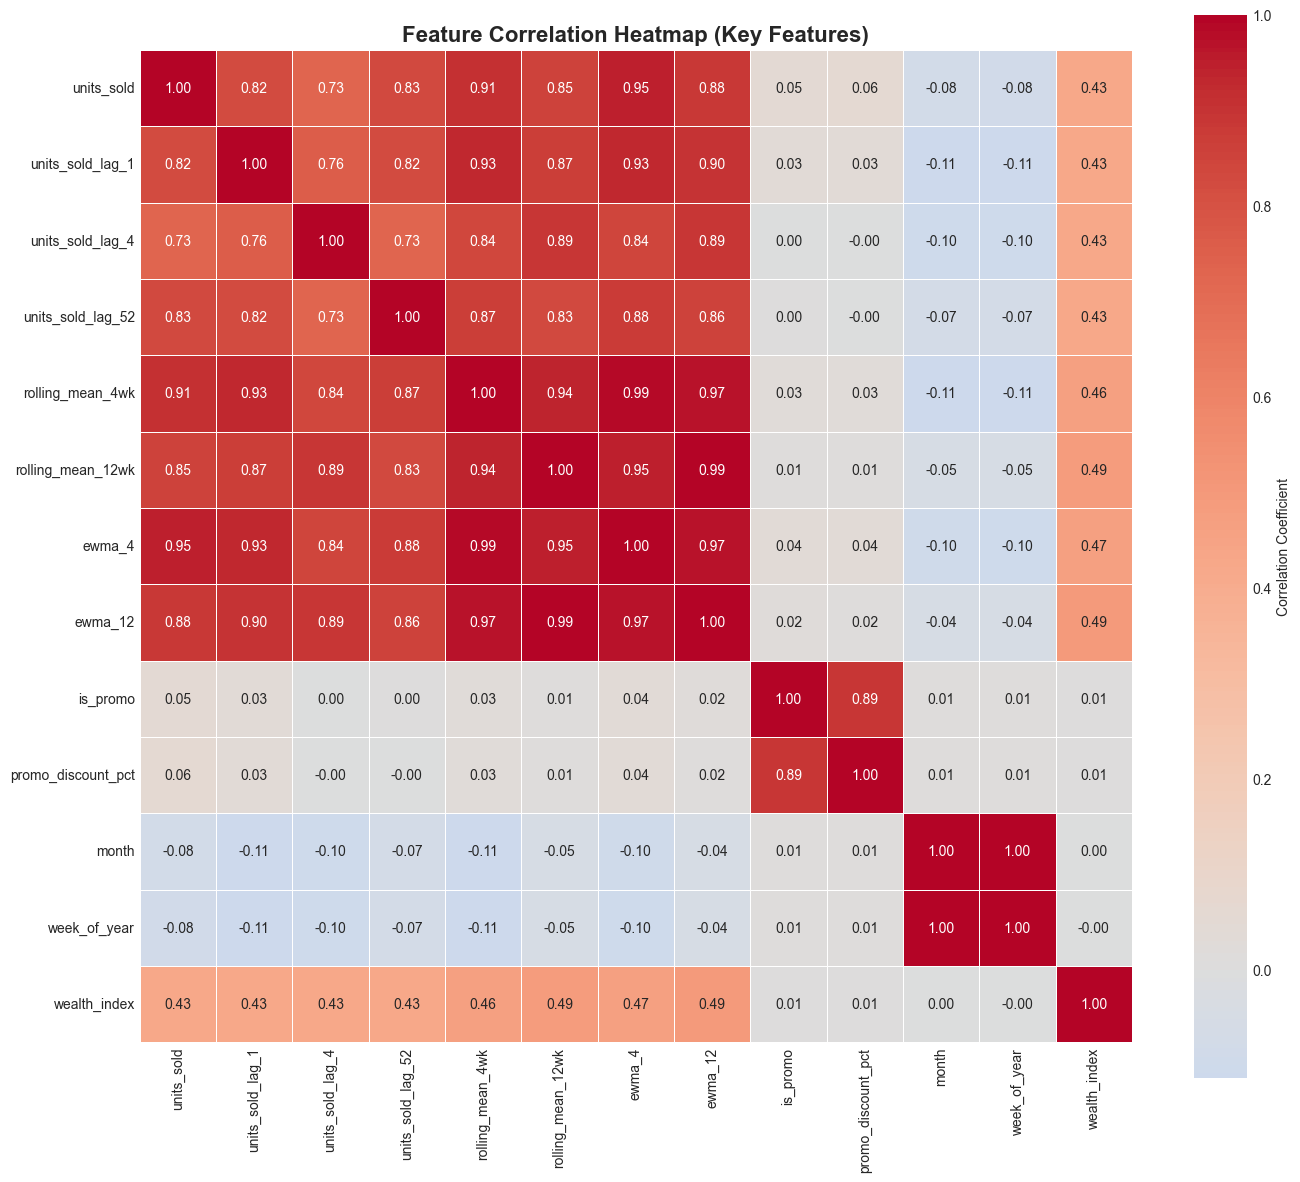

• Correlation heatmap saved!


In [22]:
# ============================================================================
# VISUALIZATION: FEATURE CORRELATIONS
# ============================================================================

print("• Creating correlation heatmap...")

# Select numeric features for correlation
numeric_features = df_full.select_dtypes(include=[np.number]).columns.tolist()

# Limit to most important features for clarity
key_features = [
    'units_sold',
    'units_sold_lag_1', 'units_sold_lag_4', 'units_sold_lag_52',
    'rolling_mean_4wk', 'rolling_mean_12wk',
    'ewma_4', 'ewma_12',
    'is_promo', 'promo_discount_pct',
    'month', 'week_of_year',
    'wealth_index'
]

# Filter to available columns
key_features = [f for f in key_features if f in df_full.columns]

# Calculate correlation
correlation = df_full[key_features].corr()

# Plot
plt.figure(figsize=(14, 12))
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=0.5,
            cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Feature Correlation Heatmap (Key Features)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('../docs/images/feature_correlations.png', dpi=150, bbox_inches='tight')
plt.show()

print("• Correlation heatmap saved!")

#### Summary Statistics

In [23]:
# ============================================================================
# FEATURE STATISTICS
# ============================================================================

print("• Feature Statistics Summary")
print("="*80)

# Lag features statistics
print()
print("• LAG FEATURES:")
for lag_col in lag_features[:5]:
    if lag_col in df_full.columns:
        mean_val = df_full[lag_col].mean()
        std_val = df_full[lag_col].std()
        print(f"   {lag_col:30s}: Mean = {mean_val:8.1f}, Std = {std_val:8.1f}")

# Rolling features statistics
print()
print("• ROLLING FEATURES:")
for roll_col in rolling_features[:5]:
    if roll_col in df_full.columns:
        mean_val = df_full[roll_col].mean()
        std_val = df_full[roll_col].std()
        print(f"   {roll_col:30s}: Mean = {mean_val:8.1f}, Std = {std_val:8.1f}")

# Promo distribution
print()
print("• PROMOTIONAL DISTRIBUTION:")
print(f"   • Promo weeks:     {df_full['is_promo'].sum():,} ({df_full['is_promo'].mean()*100:.1f}%)")
print(f"   • Non-promo weeks: {(df_full['is_promo']==0).sum():,}")
print(f"   • Avg discount:    {df_full[df_full['is_promo']==1]['promo_discount_pct'].mean():.1f}%")

• Feature Statistics Summary

• LAG FEATURES:
   units_sold_lag_1              : Mean =    900.5, Std =    713.9
   units_sold_lag_2              : Mean =    901.2, Std =    715.0
   units_sold_lag_4              : Mean =    902.4, Std =    717.1
   units_sold_lag_8              : Mean =    905.0, Std =    721.2
   units_sold_lag_12             : Mean =    912.1, Std =    726.4

• ROLLING FEATURES:
   rolling_mean_4wk              : Mean =    899.3, Std =    658.4
   rolling_std_4wk               : Mean =    230.2, Std =    222.0
   rolling_mean_8wk              : Mean =    896.6, Std =    636.4
   rolling_std_8wk               : Mean =    263.5, Std =    222.4
   rolling_mean_12wk             : Mean =    894.8, Std =    624.1

• PROMOTIONAL DISTRIBUTION:
   • Promo weeks:     774 (0.9%)
   • Non-promo weeks: 89,082
   • Avg discount:    17.9%


#### Final Cleanup

In [24]:
# ============================================================================
# FINAL CLEANUP & VALIDATION
# ============================================================================

print()
print("="*80)
print("• FEATURE ENGINEERING COMPLETE!")
print("="*80)
print()

print("• Dataset Ready for Modeling:")
print(f"   • Rows: {len(df_full):,}")
print(f"   • Features: {len(df_full.columns)}")
print(f"   • File size: {file_size_mb:.1f} MB")
print(f"   • Missing values: Handled (expected in lag features)")
print()

print("• Files Created:")
print("   • data/processed/features_with_lags.csv")
print("   • data/processed/feature_list.csv")
print("   • docs/images/feature_correlations.png")
print()

print("• Next Steps:")
print("   • Build SARIMA forecasting models")
print("   • Prophet with holidays")
print("   • XGBoost machine learning")
print("   • Ensemble & model comparison")
print()

print("• Key Features Created:")
print("   • 10 lag features (1, 2, 4, 8, 12, 26, 52 weeks)")
print("   • 8 rolling statistics (mean, std, max, min)")
print("   • 2 EWMA features (4-week, 12-week)")
print("   • 20+ encoded categories (one-hot)")
print("   • 5 interaction features")
print("   • 3 growth rate features")
print()

print("="*80)


• FEATURE ENGINEERING COMPLETE!

• Dataset Ready for Modeling:
   • Rows: 89,856
   • Features: 76
   • File size: 53.9 MB
   • Missing values: Handled (expected in lag features)

• Files Created:
   • data/processed/features_with_lags.csv
   • data/processed/feature_list.csv
   • docs/images/feature_correlations.png

• Next Steps:
   • Build SARIMA forecasting models
   • Prophet with holidays
   • XGBoost machine learning
   • Ensemble & model comparison

• Key Features Created:
   • 10 lag features (1, 2, 4, 8, 12, 26, 52 weeks)
   • 8 rolling statistics (mean, std, max, min)
   • 2 EWMA features (4-week, 12-week)
   • 20+ encoded categories (one-hot)
   • 5 interaction features
   • 3 growth rate features

